In [2]:
import matplotlib.pyplot as plt 
%matplotlib inline 
import numpy as np 
import pandas as pd 
import time 
import requests 
import json
from datetime import datetime
import talib


def get_btcprice(ticker,max_):
    """
    [coingeckoのAPIからビットコインの価格データを取得する]
    
    引数
    ticker{str}: ティッカー(例：bitcoin、ethereum、ripple)
    max_{str}: 期間(例：max、14days)
    
    Return
    r2{json}:価格、出来高、市場全体の時価総額
    """
    
    url = 'https://api.coingecko.com/api/v3/coins/' + ticker + '/market_chart?vs_currency=jpy&days=' + max_
    r = requests.get(url)
    r2 = json.loads(r.text) 
    return r2


def reshape_pricedata(r2):
    """
    [jsonから価格データだけをPandasに変換して抽出する]
    
    引数
    r2{json}: get_btcprice()で取得したデータ
    
    Return
    data{dataframe}: データフレーム
    """

    data = pd.DataFrame(r2['prices'])
    data.columns = ['date','price']
    date = []
    for i in data['date']:
        tsdate = int(i / 1000)
        loc = datetime.utcfromtimestamp(tsdate)
        date.append(loc)
    data.index = date
    del data['date']
    return data


#ビットコインの全期間の価格データを取得する
r2 = get_btcprice('bitcoin', 'max')
btc = reshape_pricedata(r2)

# 変化率を計算する
change = btc['price'].pct_change()

# 変化率に1を足して累積変化率を計算する
trade_return = (change+1).cumprod()
trade_return[0] = 1

# 累積変化率の前後5日文を確認する
print(trade_return.head(),trade_return[-5:])



2013-04-28    1.000000
2013-04-29    1.068560
2013-04-30    1.032309
2013-05-01    0.860728
2013-05-02    0.783953
Name: price, dtype: float64 2019-10-20 00:00:00    65.247859
2019-10-21 00:00:00    67.398587
2019-10-22 00:00:00    67.623255
2019-10-23 00:00:00    66.104065
2019-10-24 22:25:15    61.389908
Name: price, dtype: float64


C:\Users\81903\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


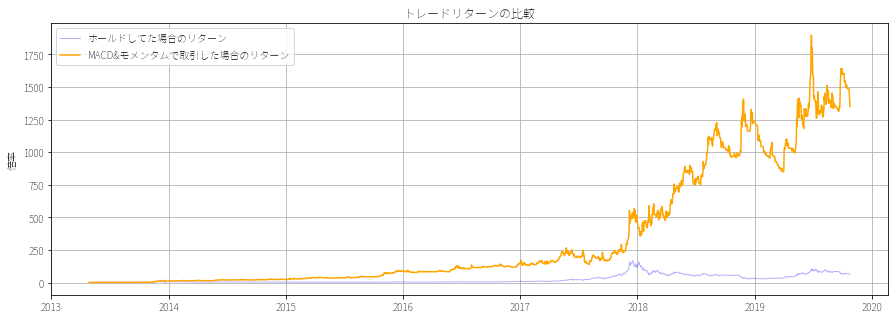

In [12]:
# 累積リターンの計算
from pylab import rcParams
import matplotlib as mpl

# フォントの設定
font = {"family":"Noto Sans CJK JP"}
mpl.rc('font', **font)
rcParams['figure.figsize'] = 15,5


def cal_backtest(price,mterm1=12,mterm2=26,mterm3=5,momterm=6):
    """
    [モメンタムとMacdを組み合わせたトレード戦略のリターンを計算する関数]
    
    mterm1{int} : macdの短期期間
    mterm2{int} : macdの長期期間
    mterm3{int} : macdの差分
    momterm{int} : モメンタムの計算期間
    
    [戻り値]
    trade_return{pdseries} : トレードパフォーマンスのホールドしていた場合との比較したデータフレーム
    
    """
    # 価格データをtalibで計算できるようにNumpyに変換
    numpyprice = np.array(price)
    
    # 変化率と累積変化率を計算
    change = price.pct_change()
    hold_return = (change + 1).cumprod()
    hold_return[0] = 1
    
    # テクニカル指標を計算
    momentum = talib.MOM(price, timeperiod=momterm)
    macd = talib.MACD(price, fastperiod=mterm1, slowperiod=mterm2, signalperiod=mterm3)
    # トレード戦略に基づいてトレードシグナルを計算(買い=1、売り=-1,ノーポジ=0)
    signal = []
    for i in range(len(price)):
        if momentum[i] > 0 and macd[2][i] > 0:
            signal.append(1)
        elif momentum[i] < 0 and macd[2][i] < 0 :
            signal.append(-1)
        else:
            signal.append(0)

    # 累積リターンの計算
    trade_returns = ((change[1:] * signal[:-1]) + 1).cumprod()
    
    # ホールドしていた場合とのリターンを比較するためにデータフレームを作成
    df = pd.DataFrame({'hold':hold_return,'trade':trade_returns})
    df3 = df.fillna(method='ffill')
    y1 = np.array(df3['hold'])
    y2 = np.array(df3['trade'])
    x = price.index[0:len(price)-1]
    return df3

# バックテストを実行
df = cal_backtest(btc['price'], mterm1=12, mterm2=26, mterm3=5, momterm=6)

# 比較結果をグラフにプロットする
plt.title('トレードリターンの比較')
plt.plot(df['hold'], 'b-', label='ホールドしてた場合のリターン', alpha=0.3, linewidth=1)
plt.plot(df['trade'], 'orange', label='MACD&モメンタムで取引した場合のリターン', alpha=1, linewidth=1.5)
plt.ylabel('倍率')
plt.grid(which='both')
plt.legend()

In [ ]:
returns=[]
for i in range(2,20):
    for r in range(2,20):
        for e in range(5,25):
            for f in range(6,30):
                returns.append([cal_backtest(price,mterm1=e,mterm2=f,mterm3=int(i),momterm=int(r)),i,r,e,f])
                print(returns[-1])
ed=np.array(returns)
ed

[42.75931925521186, 2, 2, 5, 6]
[79.97622653435779, 2, 2, 5, 7]
[104.12561192940385, 2, 2, 5, 8]
[113.3560529398394, 2, 2, 5, 9]
[108.28618855103724, 2, 2, 5, 10]
[165.0995922754769, 2, 2, 5, 11]
[161.52486365068538, 2, 2, 5, 12]
[198.41115714312335, 2, 2, 5, 13]
[152.76353517508423, 2, 2, 5, 14]
[172.59252894594144, 2, 2, 5, 15]
[286.13544240250104, 2, 2, 5, 16]
[276.28598986736387, 2, 2, 5, 17]
[269.4722846792084, 2, 2, 5, 18]
[290.4578329748174, 2, 2, 5, 19]
[217.0831772378805, 2, 2, 5, 20]
[231.5292544959495, 2, 2, 5, 21]
[174.17379262309478, 2, 2, 5, 22]
[154.55480336782193, 2, 2, 5, 23]
[167.64206127097475, 2, 2, 5, 24]
[185.53633763884542, 2, 2, 5, 25]
[193.9188877132024, 2, 2, 5, 26]
[203.1296445424, 2, 2, 5, 27]
[203.4950237078449, 2, 2, 5, 28]
[232.23357813901146, 2, 2, 5, 29]
[1.0, 2, 2, 6, 6]
[108.58878853663734, 2, 2, 6, 7]
[123.10085617396103, 2, 2, 6, 8]
[117.83621910868548, 2, 2, 6, 9]
[197.14259442945482, 2, 2, 6, 10]
[227.63265547547567, 2, 2, 6, 11]
[191.490221319842

[433.3935992742269, 2, 2, 15, 14]
[1.0, 2, 2, 15, 15]
[610.6718321944053, 2, 2, 15, 16]
[689.2201395749576, 2, 2, 15, 17]
[730.4086716869434, 2, 2, 15, 18]
[799.3722302198028, 2, 2, 15, 19]
[786.0497565640167, 2, 2, 15, 20]
[726.9302326777398, 2, 2, 15, 21]
[680.9910351512864, 2, 2, 15, 22]
[509.861794525958, 2, 2, 15, 23]
[586.1524639551501, 2, 2, 15, 24]
[745.2382928046737, 2, 2, 15, 25]
[723.6734781189257, 2, 2, 15, 26]
[825.9817706483993, 2, 2, 15, 27]
[676.9921306628147, 2, 2, 15, 28]
[645.504581075786, 2, 2, 15, 29]
[293.21625338374236, 2, 2, 16, 6]
[279.8157317553491, 2, 2, 16, 7]
[310.1213527219255, 2, 2, 16, 8]
[265.0945346429078, 2, 2, 16, 9]
[446.05001796172195, 2, 2, 16, 10]
[467.71298400295404, 2, 2, 16, 11]
[396.9805446065277, 2, 2, 16, 12]
[507.01168554904183, 2, 2, 16, 13]
[496.33059467678856, 2, 2, 16, 14]
[610.6718321944053, 2, 2, 16, 15]
[1.0, 2, 2, 16, 16]
[823.056335796806, 2, 2, 16, 17]
[876.112972159746, 2, 2, 16, 18]
[750.4237331629022, 2, 2, 16, 19]
[685.026047

[153.72833373209946, 2, 3, 5, 22]
[137.23873583518878, 2, 3, 5, 23]
[148.76464282950576, 2, 3, 5, 24]
[164.38406531897488, 2, 3, 5, 25]
[171.44934928646146, 2, 3, 5, 26]
[179.5579451055243, 2, 3, 5, 27]
[180.37323142555752, 2, 3, 5, 28]
[208.33325454090735, 2, 3, 5, 29]
[1.0, 2, 3, 6, 6]
[105.92748315618805, 2, 3, 6, 7]
[116.42878895745818, 2, 3, 6, 8]
[111.65355367975152, 2, 3, 6, 9]
[187.8439894090107, 2, 3, 6, 10]
[211.03685997163615, 2, 3, 6, 11]
[177.66802530584414, 2, 3, 6, 12]
[259.7002014356522, 2, 3, 6, 13]
[258.22161419451334, 2, 3, 6, 14]
[198.95683587280755, 2, 3, 6, 15]
[248.58621836913576, 2, 3, 6, 16]
[293.2299796124848, 2, 3, 6, 17]
[227.52722648819676, 2, 3, 6, 18]
[207.8652874232013, 2, 3, 6, 19]
[231.67312113145513, 2, 3, 6, 20]
[217.4019322560224, 2, 3, 6, 21]
[239.83455115045638, 2, 3, 6, 22]
[253.91153355994797, 2, 3, 6, 23]
[176.0449583881481, 2, 3, 6, 24]
[195.9116772524732, 2, 3, 6, 25]
[204.26644398968233, 2, 3, 6, 26]
[225.2660689050383, 2, 3, 6, 27]
[228.632

[585.4858914495258, 2, 3, 15, 28]
[574.769164642771, 2, 3, 15, 29]
[248.58621836913576, 2, 3, 16, 6]
[238.89997147772448, 2, 3, 16, 7]
[265.1298543644515, 2, 3, 16, 8]
[224.49711338550617, 2, 3, 16, 9]
[379.965186076252, 2, 3, 16, 10]
[399.2929942423891, 2, 3, 16, 11]
[339.3857042523216, 2, 3, 16, 12]
[433.13841877372306, 2, 3, 16, 13]
[425.0489836780108, 2, 3, 16, 14]
[524.2544440267422, 2, 3, 16, 15]
[1.0, 2, 3, 16, 16]
[732.0557573082122, 2, 3, 16, 17]
[779.1538162478491, 2, 3, 16, 18]
[667.3864325831075, 2, 3, 16, 19]
[606.365595620807, 2, 3, 16, 20]
[494.18869613546576, 2, 3, 16, 21]
[615.0579551937542, 2, 3, 16, 22]
[684.477908658755, 2, 3, 16, 23]
[684.4478003635807, 2, 3, 16, 24]
[720.5675782355283, 2, 3, 16, 25]
[600.6072404230159, 2, 3, 16, 26]
[591.3101876463188, 2, 3, 16, 27]
[493.86032367045465, 2, 3, 16, 28]
[506.0995683902089, 2, 3, 16, 29]
[293.2299796124848, 2, 3, 17, 6]
[226.47343471541342, 2, 3, 17, 7]
[241.13342943495812, 2, 3, 17, 8]
[368.3054925599596, 2, 3, 17, 9

[169.87262489492613, 2, 4, 6, 12]
[244.032660010463, 2, 4, 6, 13]
[243.2219629574515, 2, 4, 6, 14]
[185.3351461476206, 2, 4, 6, 15]
[231.24318355038142, 2, 4, 6, 16]
[272.18312179194834, 2, 4, 6, 17]
[208.80645204011535, 2, 4, 6, 18]
[191.32185257780938, 2, 4, 6, 19]
[212.28912936878154, 2, 4, 6, 20]
[199.18698928531904, 2, 4, 6, 21]
[219.80543316756135, 2, 4, 6, 22]
[230.57820085244424, 2, 4, 6, 23]
[159.80144291874817, 2, 4, 6, 24]
[177.79346555143465, 2, 4, 6, 25]
[185.31559120685674, 2, 4, 6, 26]
[203.96526423538933, 2, 4, 6, 27]
[207.24805596828207, 2, 4, 6, 28]
[251.01228050173992, 2, 4, 6, 29]
[101.07085456520807, 2, 4, 7, 6]
[1.0, 2, 4, 7, 7]
[123.20594842321236, 2, 4, 7, 8]
[195.67625038883014, 2, 4, 7, 9]
[170.53977605145954, 2, 4, 7, 10]
[256.40784056752886, 2, 4, 7, 11]
[233.94631250563086, 2, 4, 7, 12]
[245.47373465585065, 2, 4, 7, 13]
[220.9477950729399, 2, 4, 7, 14]
[203.68707527862747, 2, 4, 7, 15]
[219.23284134442846, 2, 4, 7, 16]
[207.52559402408124, 2, 4, 7, 17]
[182